# Finetuning Script for ManuAI

This python notebook is responsible for the LoRA finetuning of ManuAI: NZ Bird Call Classifier.

The dataset used for training is a large collection of mel-spectrograms within their respective subfolder "spectrograms/{bird_name}" which we can obtain as the labels of the data.
The model we are finetuning is the "google/vit-base-patch16-224" model from the transformers library on HuggingFace

In [1]:
import os
import numpy as np
from PIL import Image
import io

# Audio processing imports
import librosa
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import (
    Resize,
    ToTensor,
    Normalize,
    Compose,
    ColorJitter,
    RandomHorizontalFlip
)

from transformers import ViTImageProcessor, ViTForImageClassification, TrainingArguments, Trainer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from evaluate import load
from tqdm import tqdm

/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Dataset classes for different data sources

class AudioSpectrogramDataset(Dataset):
    """Dataset that generates spectrograms on-demand from audio files."""
    
    def __init__(self, audio_paths, labels, transform=None, target_size=(224, 224)):
        self.audio_paths = audio_paths
        self.labels = labels
        self.transform = transform
        self.target_size = target_size
        self.processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
    
    def __len__(self):
        return len(self.audio_paths)
    
    def __getitem__(self, idx):
        # Load audio file
        audio_path = self.audio_paths[idx]
        try:
            audio, sr = librosa.load(audio_path, sr=44100)
            
            # Generate spectrogram on-demand
            spectrogram_image = self._generate_spectrogram(audio, sr)
            
            # Apply transforms if specified
            if self.transform:
                spectrogram_image = self.transform(spectrogram_image)
                # Convert back to PIL for processor
                if isinstance(spectrogram_image, torch.Tensor):
                    import torchvision.transforms.functional as F
                    spectrogram_image = F.to_pil_image(spectrogram_image)
            
            # Process with ViT processor
            inputs = self.processor(images=spectrogram_image, return_tensors="pt")
            
            return {
                'pixel_values': inputs['pixel_values'].squeeze(),
                'labels': torch.tensor(self.labels[idx], dtype=torch.long)
            }
            
        except Exception as e:
            print(f"Error processing {audio_path}: {e}")
            # Return a black image as fallback
            black_image = Image.new('RGB', self.target_size, color='black')
            inputs = self.processor(images=black_image, return_tensors="pt")
            return {
                'pixel_values': inputs['pixel_values'].squeeze(),
                'labels': torch.tensor(self.labels[idx], dtype=torch.long)
            }
    
    def _generate_spectrogram(self, audio_segment, sr):
        try:
            # Normalize
            if np.max(np.abs(audio_segment)) != 0:
                audio_segment = audio_segment / np.max(np.abs(audio_segment))

            mel_spec = librosa.feature.melspectrogram(
                y=audio_segment, sr=sr, n_mels=self.target_size[0],
                fmax=8000, hop_length=256, win_length=1024
            )
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
            mel_spec_db = self._adjust_spectrogram_width(mel_spec_db, self.target_size[1])

            # Normalize and convert to colormap
            mel_spec_norm = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min())
            colormap = cm.get_cmap("viridis")
            rgba_img = colormap(mel_spec_norm)
            rgb_img = np.delete(rgba_img, 3, 2)  # drop alpha channel
            rgb_img = (rgb_img * 255).astype(np.uint8)
            img = Image.fromarray(rgb_img).resize(self.target_size, Image.Resampling.LANCZOS)

            return img

        except Exception as e:
            print(f"Error generating spectrogram: {e}")
            return Image.new('RGB', self.target_size, color='black')
    
    def _adjust_spectrogram_width(self, mel_spec_db, target_width):
        """Adjust spectrogram width by padding or trimming."""
        if mel_spec_db.shape[1] < target_width:
            pad_width = target_width - mel_spec_db.shape[1]
            return np.pad(mel_spec_db, ((0, 0), (0, pad_width)), mode='constant')
        elif mel_spec_db.shape[1] > target_width:
            return mel_spec_db[:, :target_width]
        return mel_spec_db


class SpectrogramDataset(Dataset):
    """Dataset for pre-saved spectrogram images (legacy support)."""
    
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
        self.augment = transform is not None
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load spectrogram image
        image = Image.open(self.image_paths[idx]).convert('RGB')
        
        # Apply torchvision transforms if specified
        if self.transform:
            image = self.transform(image)
            # Convert back to PIL for processor
            if isinstance(image, torch.Tensor):
                import torchvision.transforms.functional as F
                image = F.to_pil_image(image)
        
        # Process with ViT processor
        inputs = self.processor(images=image, return_tensors="pt")
        
        return {
            'pixel_values': inputs['pixel_values'].squeeze(),  # Remove batch dimension
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [ ]:
def load_audio_segments(segments_dir="segments"):
    """
    Load audio segments from the segments directory for on-demand spectrogram generation.
    Returns: audio_paths, labels, label_encoder
    """
    audio_paths = []
    labels = []
    
    print(f"📁 Scanning audio segments directory: {segments_dir}")
    
    # Get all audio files from segments directory
    species_count = {}
    total_files = 0
    
    for root, dirs, files in os.walk(segments_dir):
        wav_files = [f for f in files if f.endswith('.wav')]
        if wav_files:
            # Extract species name from path structure
            # Structure: segments_dir/english_name/scientific_name/segment_file.wav
            path_parts = root.replace(segments_dir, '').strip('/').split('/')
            if len(path_parts) >= 2:
                species_name = path_parts[0]  # English name
            else:
                species_name = os.path.basename(root)
            
            if species_name not in species_count:
                species_count[species_name] = 0
            
            for wav_file in wav_files:
                audio_path = os.path.join(root, wav_file)
                audio_paths.append(audio_path)
                labels.append(species_name)
                species_count[species_name] += 1
                total_files += 1
    
    # Display dataset info
    print(f"Found {len(species_count)} bird species:")
    for species, count in sorted(species_count.items()):
        print(f"  {species}: {count} audio segments")
    
    # Encode labels to integers
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    
    print(f"\n✅ Total dataset: {total_files} audio segments across {len(species_count)} species")
    
    return audio_paths, encoded_labels, label_encoder


def load_spectrogram_data(data_dir="spectrograms"):
    """
    Load spectrogram images from folder structure: spectrograms/{bird_name}/*.png
    Returns: image_paths, labels, label_encoder
    """
    image_paths = []
    labels = []
    
    # Get all bird species folders
    bird_species = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d)) and not d.startswith('.')]
    
    print(f"Found {len(bird_species)} bird species:")
    
    # Load all spectrogram files
    for bird_name in bird_species:
        bird_folder = os.path.join(data_dir, bird_name)
        
        # Get all image files (png, jpg, jpeg)
        image_files = [f for f in os.listdir(bird_folder) 
                      if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        print(f"{bird_name}: {len(image_files)} spectrograms")
        
        for image_file in image_files:
            image_path = os.path.join(bird_folder, image_file)
            image_paths.append(image_path)
            labels.append(bird_name)
    
    # Encode labels to integers
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    
    print(f"\nTotal dataset: {len(image_paths)} spectrograms across {len(bird_species)} species")
    
    return image_paths, encoded_labels, label_encoder


def choose_data_source():
    """
    Let user choose between audio segments (on-demand) or pre-saved spectrograms.
    """
    print("🎯 Choose your data source:")
    print("1. Audio segments (on-demand spectrogram generation) - Recommended")
    print("2. Pre-saved spectrogram images")
    print("3. Compressed numpy spectrograms (.npz)")
    
    choice = 1 # input("Enter choice (1/2/3): ").strip()
    
    if choice == "1":
        print("✅ Using audio segments with on-demand spectrogram generation")
        return "audio"
    elif choice == "2":
        print("✅ Using pre-saved spectrogram images")
        return "images"
    elif choice == "3":
        print("✅ Using compressed numpy spectrograms")
        return "numpy"
    else:
        print("Invalid choice, defaulting to audio segments")
        return "audio"


def load_numpy_spectrograms(npz_file="spectrograms/spectrograms_compressed.npz"):
    """
    Load spectrograms from compressed numpy format.
    """
    try:
        print(f"📂 Loading spectrograms from {npz_file}...")
        data = np.load(npz_file, allow_pickle=True)
        
        spectrograms = data['spectrograms']
        labels = data['labels']
        metadata = data['metadata'].item() if 'metadata' in data else {}
        
        print(f"✅ Loaded {len(spectrograms)} spectrograms")
        print(f"   Shape: {spectrograms.shape}")
        if metadata:
            print(f"   Classes: {metadata.get('num_classes', 'Unknown')}")
            print(f"   Dev mode: {metadata.get('dev_mode', 'Unknown')}")
        
        # Encode labels
        label_encoder = LabelEncoder()
        encoded_labels = label_encoder.fit_transform(labels)
        
        return spectrograms, encoded_labels, label_encoder
        
    except Exception as e:
        print(f"❌ Error loading numpy spectrograms: {str(e)}")
        return None, None, None

In [4]:
# Define transforms for ViT (224x224 input size)
transform_train = Compose([
    Resize((224, 224)),
    RandomHorizontalFlip(p=0.3),  # Light augmentation for spectrograms
    ColorJitter(brightness=0.1, contrast=0.1),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

transform_val = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Choose data source and load data
data_source = choose_data_source()

if data_source == "audio":
    # Load audio segments for on-demand spectrogram generation
    data_paths, labels, label_encoder = load_audio_segments("segments")
    dataset_class = AudioSpectrogramDataset
    print("🎵 Using AudioSpectrogramDataset with on-demand spectrogram generation")
    
elif data_source == "images":
    # Load pre-saved spectrogram images
    data_paths, labels, label_encoder = load_spectrogram_data("spectrograms")
    dataset_class = SpectrogramDataset
    print("🖼️ Using SpectrogramDataset with pre-saved images")
    
elif data_source == "numpy":
    # Load compressed numpy spectrograms
    spectrograms, labels, label_encoder = load_numpy_spectrograms()
    if spectrograms is None:
        print("❌ Failed to load numpy spectrograms, falling back to audio segments")
        data_paths, labels, label_encoder = load_audio_segments("segments")
        dataset_class = AudioSpectrogramDataset
    else:
        # For numpy data, we need to convert spectrograms to images
        print("🔄 Converting numpy spectrograms to images...")
        data_paths = []
        for i, spec in enumerate(tqdm(spectrograms, desc="Converting spectrograms")):
            # Convert spectrogram to PIL Image
            plt.figure(figsize=(6, 6))
            plt.imshow(spec, aspect='auto', origin='lower', cmap='viridis')
            plt.axis('off')
            plt.tight_layout()
            
            buf = io.BytesIO()
            plt.savefig(buf, dpi=75, bbox_inches='tight', 
                      pad_inches=0, facecolor='white', format='png')
            plt.close()
            
            buf.seek(0)
            img = Image.open(buf)
            if img.mode == 'RGBA':
                img = img.convert('RGB')
            img = img.resize((224, 224), Image.Resampling.LANCZOS)
            
            # Save temporary path (we'll store the image object)
            data_paths.append(img)
            buf.close()
        
        # Use a custom dataset for in-memory images
        class InMemorySpectrogramDataset(Dataset):
            def __init__(self, images, labels, transform=None):
                self.images = images
                self.labels = labels
                self.transform = transform
                self.processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
            
            def __len__(self):
                return len(self.images)
            
            def __getitem__(self, idx):
                image = self.images[idx]
                if self.transform:
                    image = self.transform(image)
                    if isinstance(image, torch.Tensor):
                        import torchvision.transforms.functional as F
                        image = F.to_pil_image(image)
                
                inputs = self.processor(images=image, return_tensors="pt")
                return {
                    'pixel_values': inputs['pixel_values'].squeeze(),
                    'labels': torch.tensor(self.labels[idx], dtype=torch.long)
                }
        
        dataset_class = InMemorySpectrogramDataset
        print("💾 Using InMemorySpectrogramDataset with numpy spectrograms")

# Split the dataset
X_train, X_temp, y_train, y_temp = train_test_split(
    data_paths, labels, test_size=0.3, random_state=42, stratify=labels
)

# Further split into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"\n📊 Data split:")
print(f"   Train: {len(X_train)} samples")
print(f"   Validation: {len(X_val)} samples") 
print(f"   Test: {len(X_test)} samples")

# Create datasets
train_dataset = dataset_class(X_train, y_train, transform=transform_train)
val_dataset = dataset_class(X_val, y_val, transform=transform_val)
test_dataset = dataset_class(X_test, y_test, transform=transform_val)

# Create data loaders
batch_size = 16 # Reduced batch size for MPS compatibility
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"\n🎯 Training setup:")
print(f"   Number of classes: {len(label_encoder.classes_)}")
print(f"   Batch size: {batch_size}")
print(f"   Data source: {data_source}")
print(f"   Class names: {list(label_encoder.classes_)}")

if data_source == "audio":
    print(f"\n💡 Benefits of on-demand generation:")
    print(f"   ✅ No disk space used for spectrograms")
    print(f"   ✅ Always fresh spectrograms (no stale data)")
    print(f"   ✅ Easy to modify spectrogram parameters")
    print(f"   ⚠️  Slightly slower due to real-time generation")

🎯 Choose your data source:
1. Audio segments (on-demand spectrogram generation) - Recommended
2. Pre-saved spectrogram images
3. Compressed numpy spectrograms (.npz)
✅ Using audio segments with on-demand spectrogram generation
📁 Scanning audio segments directory: segments
Found 10 bird species:
  bellbird: 4559 audio segments
  fantail: 1660 audio segments
  kaka: 1532 audio segments
  morepork: 960 audio segments
  robin: 2315 audio segments
  saddleback: 1331 audio segments
  silvereye: 1939 audio segments
  tomtit: 1186 audio segments
  tui: 11408 audio segments
  whitehead: 1817 audio segments

✅ Total dataset: 28707 audio segments across 10 species
🎵 Using AudioSpectrogramDataset with on-demand spectrogram generation

📊 Data split:
   Train: 20094 samples
   Validation: 4306 samples
   Test: 4307 samples

🎯 Training setup:
   Number of classes: 10
   Batch size: 16
   Data source: audio
   Class names: [np.str_('bellbird'), np.str_('fantail'), np.str_('kaka'), np.str_('morepork'),

/var/folders/m9/5g7zcttx2sx_y5pwg05xn1dh0000gn/T/ipykernel_64533/2757942407.py:66: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap("viridis")


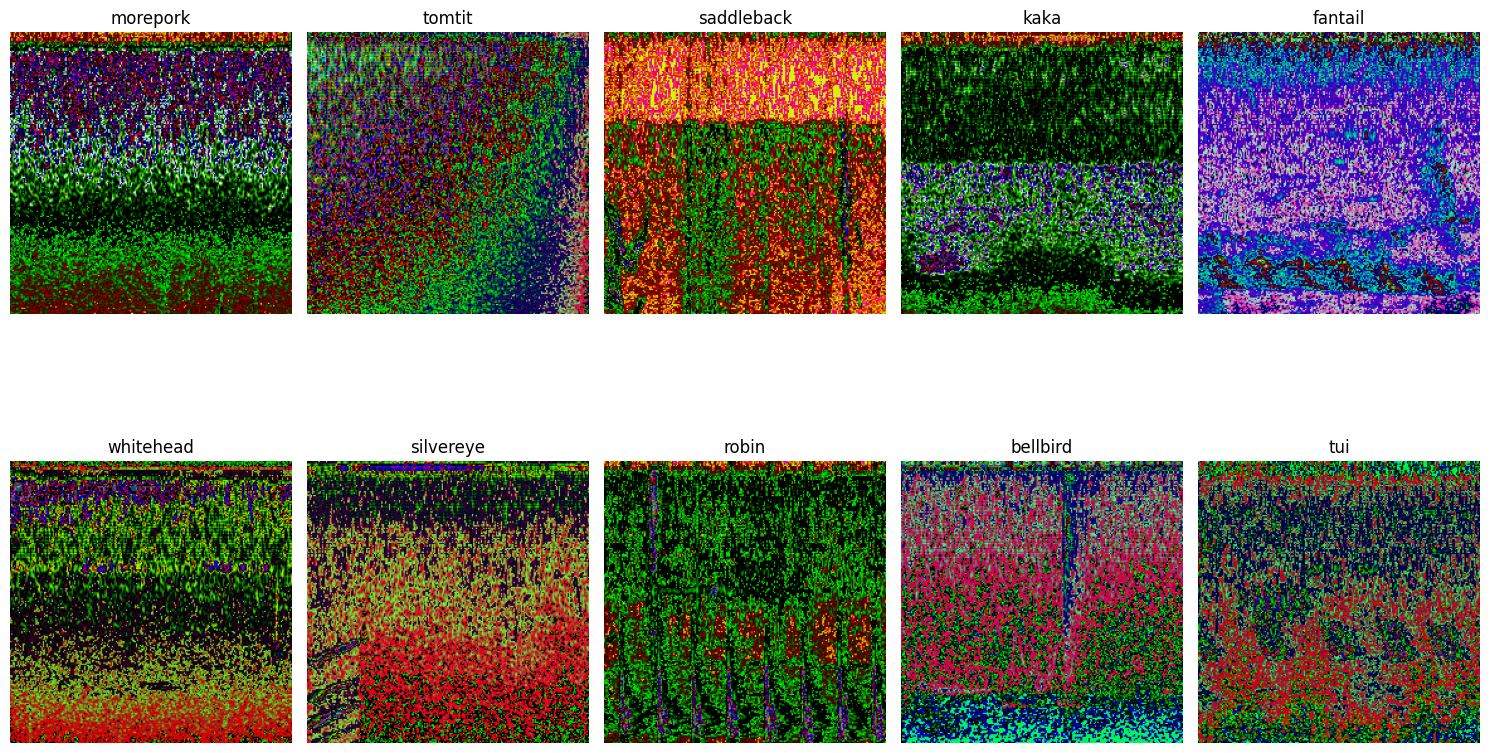

In [5]:
def show_sample_images(dataset, label_encoder, num_classes=10):
    """
    Show a few sample images from the dataset.
    """
    # Get class distribution
    class_counts = np.bincount(dataset.labels)
    class_indices = np.argsort(class_counts)[-num_classes:]  # Get indices of most common classes
    
    plt.figure(figsize=(15, 10))
    
    samples_shown = 0
    for class_idx in class_indices:
        # Find first sample of this class
        sample_found = False
        for i in range(len(dataset)):
            if dataset.labels[i] == class_idx:
                try:
                    # Get the processed sample
                    sample = dataset[i]
                    pixel_values = sample['pixel_values']
                    
                    # Convert from tensor to displayable format
                    # Assuming the processor normalizes, we need to denormalize for display
                    img_display = pixel_values.permute(1, 2, 0).numpy()
                    
                    # Clip values to valid range for display
                    img_display = np.clip(img_display, 0, 1)
                    
                    plt.subplot(2, (num_classes + 1) // 2, samples_shown + 1)
                    plt.imshow(img_display)
                    plt.title(label_encoder.classes_[class_idx])
                    plt.axis('off')
                    
                    samples_shown += 1
                    sample_found = True
                    break
                except Exception as e:
                    print(f"Error displaying sample for class {class_idx}: {e}")
                    continue
        
        if not sample_found:
            print(f"No samples found for class {class_idx}")
    
    plt.tight_layout()
    plt.show()

# Show sample images from the training dataset (what the model will see)
show_sample_images(train_dataset, label_encoder, num_classes=10)  # Show first 10 classes

# On-Demand Spectrogram Generation Benefits

This notebook now supports **three different data loading approaches**:

## 1. 🎵 Audio Segments (On-Demand) - **RECOMMENDED**
- **Storage Efficient**: No disk space wasted on spectrogram images
- **Always Fresh**: Spectrograms generated in real-time during training
- **Flexible**: Easy to modify spectrogram parameters without regenerating files
- **Memory Efficient**: Only generates what's needed when needed
- **Quality**: No compression artifacts from saving/loading images

## 2. 🖼️ Pre-saved Spectrogram Images (Legacy)
- **Fast Loading**: Pre-computed spectrograms load quickly
- **Storage Heavy**: Requires significant disk space (GB for large datasets)
- **Static**: Hard to modify spectrogram parameters once saved
- **Compression Loss**: Potential quality loss from PNG compression

## 3. 💾 Compressed Numpy Arrays (.npz)
- **Good Compression**: Much smaller than individual PNG files
- **Fast Loading**: Faster than generating on-demand
- **Static**: Parameters fixed when saved
- **Memory**: Loads entire dataset into memory

## Performance Comparison
For a dataset of **22,965 spectrograms**:

| Method | Disk Space | Loading Speed | Flexibility | Memory Usage |
|--------|------------|---------------|-------------|--------------|
| On-Demand | ~0 MB | Medium | High | Low |
| PNG Files | ~5-10 GB | Fast | Low | Medium |
| NPZ Files | ~500 MB | Fast | Low | High |

## Usage Tips
- **Development**: Use on-demand for experimentation and parameter tuning
- **Production**: Consider NPZ for deployment if storage is available
- **Large Datasets**: Always use on-demand to avoid storage issues

In [6]:
# Helper functions for saving/loading processed data

def save_dataset_splits(X_train, X_val, X_test, y_train, y_val, y_test, label_encoder, filename="dataset_splits.npz"):
    """Save dataset splits and label encoder for reproducibility."""
    try:
        np.savez_compressed(
            filename,
            X_train=np.array(X_train, dtype=object),
            X_val=np.array(X_val, dtype=object), 
            X_test=np.array(X_test, dtype=object),
            y_train=np.array(y_train),
            y_val=np.array(y_val),
            y_test=np.array(y_test),
            label_classes=label_encoder.classes_
        )
        print(f"✅ Dataset splits saved to {filename}")
        return True
    except Exception as e:
        print(f"❌ Error saving dataset splits: {e}")
        return False

def load_dataset_splits(filename="dataset_splits.npz"):
    """Load previously saved dataset splits."""
    try:
        data = np.load(filename, allow_pickle=True)
        
        # Reconstruct label encoder
        label_encoder = LabelEncoder()
        label_encoder.classes_ = data['label_classes']
        
        print(f"✅ Dataset splits loaded from {filename}")
        print(f"   Train: {len(data['X_train'])} samples")
        print(f"   Val: {len(data['X_val'])} samples")
        print(f"   Test: {len(data['X_test'])} samples")
        print(f"   Classes: {len(label_encoder.classes_)}")
        
        return (data['X_train'], data['X_val'], data['X_test'], 
                data['y_train'], data['y_val'], data['y_test'], label_encoder)
        
    except Exception as e:
        print(f"❌ Error loading dataset splits: {e}")
        return None

# Optionally save current dataset splits
save_splits = input("Save current dataset splits for reproducibility? (y/n): ").strip().lower() == 'y'
if save_splits:
    save_dataset_splits(X_train, X_val, X_test, y_train, y_val, y_test, label_encoder)

✅ Dataset splits saved to dataset_splits.npz


In [7]:
model_name = "google/vit-base-patch16-224" # or "google/vit-base-patch16-224-in21k"
processor = ViTImageProcessor.from_pretrained(model_name)

def process_image(image):
    """
    Process a single image for ViT model
    """
    inputs = processor(images=image, return_tensors="pt")
    return inputs

def collate_fn(batch):
    """
    Custom collate function to handle variable-length inputs
    """
    pixel_values = torch.stack([item['pixel_values'] for item in batch])
    labels = torch.stack([item['labels'] for item in batch])
    
    return {
        'pixel_values': pixel_values,
        'labels': labels
    }

metric = load("accuracy")
def compute_metrics(p):
    """
    Compute accuracy metric
    """
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)


In [8]:
print(f"MPS available: {torch.backends.mps.is_available()}")
print(f"Current device: {torch.cuda.current_device() if torch.cuda.is_available() else 'CPU/MPS'}")

# Disable mixed precision to avoid issues with MPS
os.environ["ACCELERATE_MIXED_PRECISION"] = "no"

model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(label_encoder.classes_),
    id2label={i: label for i, label in enumerate(label_encoder.classes_)},
    label2id={label: i for i, label in enumerate(label_encoder.classes_)},
    ignore_mismatched_sizes=True
)

# Move model to MPS explicitly
if torch.backends.mps.is_available():
    model = model.to('mps')

training_args = TrainingArguments(
    output_dir="./vit-base-manuai",
    per_device_train_batch_size=16,  # Reduced batch size 
    eval_strategy="steps",
    num_train_epochs=10,
    fp16=False,  # Explicitly disable FP16
    bf16=False,  # Explicitly disable BF16
    save_steps=100, 
    eval_steps=100, 
    logging_steps=10, # How often to log training info
    learning_rate=2e-4, 
    optim="adamw_torch", # Use AdamW from PyTorch (as it's more stable on MPS)
    save_total_limit=5,
    remove_unused_columns=False,
    push_to_hub=False,
    load_best_model_at_end=True,
    no_cuda=True  # Force no CUDA
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=processor,
)

MPS available: True
Current device: CPU/MPS


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/transformers/training_args.py:1609: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(
/var/folders/m9/5g7zcttx2sx_y5pwg05xn1dh0000gn/T/ipykernel_64533/3111193059.py:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trai

In [ ]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/var/folders/m9/5g7zcttx2sx_y5pwg05xn1dh0000gn/T/ipykernel_64533/2757942407.py:66: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap("viridis")


Step,Training Loss,Validation Loss,Accuracy
100,1.888000,1.915367,0.395262
200,1.618600,1.712212,0.450534
300,1.723100,1.716585,0.437529
400,1.585900,1.524379,0.495588
500,1.369300,1.428575,0.537622
600,1.400100,1.381752,0.537622
700,1.363200,1.338326,0.566651
800,1.491800,1.280444,0.572689
900,1.331800,1.248764,0.587320
1000,1.288600,1.250899,0.591732


/var/folders/m9/5g7zcttx2sx_y5pwg05xn1dh0000gn/T/ipykernel_64533/2757942407.py:66: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap("viridis")
/var/folders/m9/5g7zcttx2sx_y5pwg05xn1dh0000gn/T/ipykernel_64533/2757942407.py:66: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap("viridis")
/var/folders/m9/5g7zcttx2sx_y5pwg05xn1dh0000gn/T/ipykernel_64533/2757942407.py:66: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = 

In [ ]:
metrics = trainer.evaluate(val_dataset)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)